In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: medium_post_titles.csv  


In [ ]:
!pip install pattern --upgrade nltk gensim==3.8.0 bokeh

# Обработка данных

In [3]:
import numpy as np
import pandas as pd
import re
import pattern
from pattern.en import lemma, lexeme
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn')
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Анализ и очистка

In [4]:
data = pd.read_csv("medium_post_titles.csv")

In [5]:
data.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",NaN,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False


In [6]:
data.shape

(126418, 4)

In [7]:
data.isna().sum()

category                      0
title                         0
subtitle                   1487
subtitle_truncated_flag       0
dtype: int64

In [8]:
list(data[data.subtitle.isna()].title)[:10]

['"Call me Nat Love" :Black Cowboys and the Frontiers of American Freedom',
 '#UprootedChildhoods - Growing up with evictions',
 '(In)visibility: the impact of misogyny and lesbophobia on building a positive lesbian self',
 '10 90s websites designs you won’t believe existed',
 '10 Essential Tips for Vetting a Software Development Agency',
 '10 Iconic Signs in New York City',
 '10 Misconceptions About Employee Motivation',
 '10 Tricks to Appear Smart During Meetings',
 '10 Ways to Avoid Burnout in The Workplace',
 '10 inspiring hero image websites']

In [9]:
list(data[data.subtitle.isna()].category)[:10]

['equality',
 'family',
 'equality',
 'visual-design',
 'startups',
 'travel',
 'work',
 'humor',
 'work',
 'marketing']

Не будем удалять объекты, где пропущены значения признака`subtitle`, т.к. признак `title` содержит достаточно показательные слова

In [10]:
#data.dropna(inplace = True)

In [11]:
data.fillna("", inplace=True)

In [12]:
np.sum(data.duplicated())

0

In [13]:
data.category.value_counts()

culture            5070
equality           5054
work               4805
politics           4777
writing            4035
                   ... 
medium-magazine     105
psychedelics         94
race                 84
privacy              77
venture-capital      39
Name: category, Length: 93, dtype: int64

In [14]:
data.category.value_counts().describe()

count      93.000000
mean     1359.333333
std      1224.381604
min        39.000000
25%       329.000000
50%      1048.000000
75%      2008.000000
max      5070.000000
Name: category, dtype: float64

Оставим категории, к которым относится основная часть статей, и не будем рассмаривать категории, где статей слишком мало

In [15]:
data.category.value_counts()[data.category.value_counts() > 2008]

culture                    5070
equality                   5054
work                       4805
politics                   4777
writing                    4035
business                   3738
javascript                 3614
mental-health              3129
artificial-intelligence    2899
relationships              2800
social-media               2662
health                     2624
family                     2615
economy                    2605
software-engineering       2545
science                    2477
environment                2388
technology                 2386
machine-learning           2246
travel                     2191
marketing                  2178
cryptocurrency             2160
music                      2100
Name: category, dtype: int64

In [16]:
categories = data.category.value_counts()[data.category.value_counts() > 2008].index

In [17]:
data.loc[data['category'].isin(categories)]

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False
5,cryptocurrency,"""Cypherpunks and Wall Street"": The Security To...",Bruce Fenton presents at the World Blockchain ...,False
6,politics,"""Diss"" vs. ""Piss"": The Blue Wave and Yellow Tr...",Michael Gofman & Matthew Wigler explore how bu...,False
...,...,...,...,...
126412,javascript,🚀 Infinite Currying in Javascript,Javascript is an interesting language with a l...,True
126413,javascript,🚀 Introducing Akita: A New State Management Pa...,Every developer knows state management is diff...,True
126414,cryptocurrency,🚀Sudden Bitcoin Price Breakout Sets New Bull T...,Short-term trend: Bullish (but overbought),False
126415,artificial-intelligence,🤖 Hack4th0n & RASA chatbot,Past week I took part in an internal Hackathon...,True


In [18]:
data = data.loc[data['category'].isin(categories)]

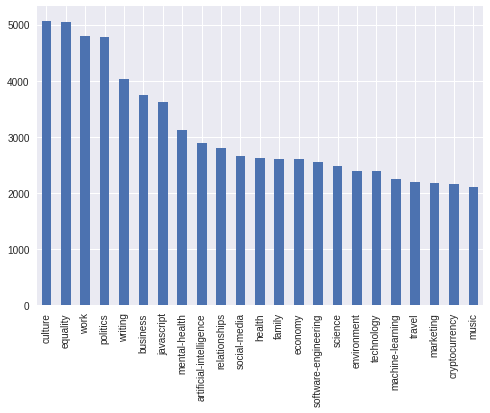

In [19]:
data.category.value_counts().plot(kind='bar');

Статьи распределены достаточно равномерно

In [21]:
data_raw = list(data['description'])

In [22]:
data_raw[:10]

['"21 Conversations" - A fun (and easy) game for teams to get to know each other A (new?) Icebreaker game to get your team to say all the interesting stuff',
 '"Call me Nat Love" :Black Cowboys and the Frontiers of American Freedom ',
 '"Can I Train my Model on Your Computer?" How we waste computational resources and how to stop it.',
 '"Cypherpunks and Wall Street": The Security Token Revolution & Regulation Bruce Fenton presents at the World Blockchain Forum\u200a-\u200aand will cryptocurrency bring us to utopia or dystopia?',
 '"Diss" vs. "Piss": The Blue Wave and Yellow Trickle in California\'s Central Valley Michael Gofman & Matthew Wigler explore how bucking the party line can be key to building a winning coalition in California\'s 21st District',
 '"Doctor, he\'s gone into shock!" You\'ve seen it in movies and on television.  But what does it mean? Here\'s a Quick & Dirty Guide to Shock.',
 '"Happily Ever After: Fairy Tales for Every Child", or the Underrated HBO Show That Tried

In [23]:
data_raw[-1][0]

'🤖'

Очистим данные, удалим стоп слова и сделаем лемматизацию

In [24]:
def clear_data(X):
    
    for i in range(len(X)):
        
        X[i] = re.sub(r'\'s', "", X[i])
        X[i] = re.sub(r'\'st', "", X[i])
        X[i] = re.sub(r'\'nd', "", X[i])
        X[i] = re.sub(r'\'th', "", X[i])
        X[i] = re.sub(r'\d', "", X[i])
        X[i] = re.sub(r'[^\w\s\']', "", X[i])
        string_encode = X[i].encode("ascii", "ignore")
        X[i] = string_encode.decode()
        

In [25]:
clear_data(data_raw)

In [26]:
data_raw[:15]

[' Conversations  A fun and easy game for teams to get to know each other A new Icebreaker game to get your team to say all the interesting stuff',
 'Call me Nat Love Black Cowboys and the Frontiers of American Freedom ',
 'Can I Train my Model on Your Computer How we waste computational resources and how to stop it',
 'Cypherpunks and Wall Street The Security Token Revolution  Regulation Bruce Fenton presents at the World Blockchain Forumand will cryptocurrency bring us to utopia or dystopia',
 'Diss vs Piss The Blue Wave and Yellow Trickle in California Central Valley Michael Gofman  Matthew Wigler explore how bucking the party line can be key to building a winning coalition in California st District',
 "Doctor he gone into shock You've seen it in movies and on television  But what does it mean Here a Quick  Dirty Guide to Shock",
 'Happily Ever After Fairy Tales for Every Child or the Underrated HBO Show That Tried to Tackle Television shows have an invaluable opportunity namely tha

In [28]:
sw = stopwords.words('english') + \
     [wd.replace("'", "") for wd in stopwords.words('english')] + \
     ['go', 'make', 'get', 'let', 'like', 'need', 'know', 'v' ,'u', 'one', 'new', \
      'time', 'say', 'take']

tokenizer = WordPunctTokenizer()
data_tokenized = [tokenizer.tokenize(seq.lower()) for seq in data_raw]

# при первом запуске падает
def lemmatize(data, sw):
  for i in range(len(data)):
    try:
      data[i] = [lemma(wd) for wd in data[i]]
    except StopIteration:
      continue
    data[i] = [wd for wd in data[i] if wd not in sw]

lemmatize(data_tokenized, sw)

In [29]:
for seq in data_tokenized[:10]:
  print(" ".join(seq))

conversation fun easy game team icebreaker game team interest stuff
call nat love black cowboy frontier american freedom
train model computer waste computational resource stop
cypherpunk wall street security token revolution regulation bruce fenton present world blockchain forumand cryptocurrency bring utopia dystopia
dis piss blue wave yellow trickle california central valley michael gofman matthew wigler explore buck party line key build win coalition california st district
doctor shock see movy television mean quick dirty guide shock
happily ever fairy tale every child underrate hbo show try tackle television show invaluable opportunity namely shape way children view world
kill eve women love murder murderino assemble
level experiment tcr participation ensure notaswealthy user active participation tokencurate registry
neecie big sister denise neecie big dream slow


In [30]:
data['clear_text'] = data_tokenized

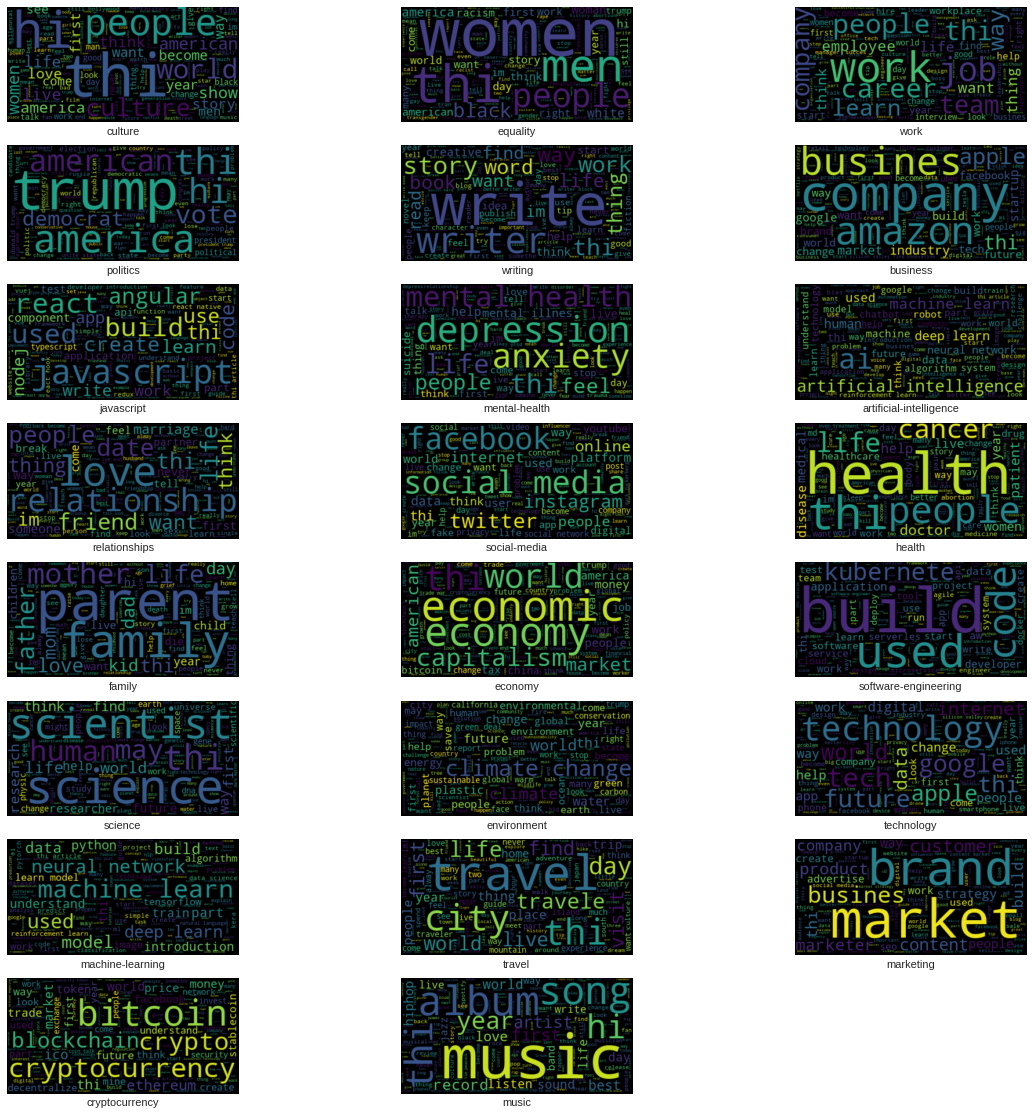

In [31]:
plt.figure(figsize=(20,20))

for i, category in enumerate(categories):
    cat_vocab = data[data.category == category]['clear_text'].sum()

    wc = WordCloud(background_color="black")
    wc.generate(" ".join(cat_vocab))

    plt.subplot(8, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wc, interpolation="bilinear")
    plt.xlabel("{}".format(category))
    plt.grid(False)
    
plt.show()

Можно заметить, что в самые часто встречающиеся слова в каждой категории хорошо ее характеризуют. Исключения составляют слова `thi` (видимо `think`) и `hi`, удалим их, а также редко встречающиеся слова.

In [ ]:
%%time
for category in categories:
  cat_vocab = data[data.category == category]['clear_text']
  idx = cat_vocab.index
  word_freq = pd.Series(cat_vocab.sum()).value_counts()

  less_freq = list(word_freq[word_freq <= word_freq.quantile(0.75)].index)
  most_freq = ['thi', 'hi']
  stop_words = less_freq + most_freq
  tmp_tokens = []
  for i in range(cat_vocab.shape[0]):
    tmp_tokens.append([wd for wd in cat_vocab.iloc[i] if wd not in stop_words])
  data['clear_text'].loc[idx] = tmp_tokens

In [33]:
empty_idx = []
for i, row in data['clear_text'].iteritems():
  if len(row) == 0:
    empty_idx.append(i)

In [34]:
data.loc[empty_idx]

,category,title,subtitle,subtitle_truncated_flag,description,clear_text
205,equality,#WhoWillYouHelp,https://youtu.be/opPb2E3bkoo,False,#WhoWillYouHelp https://youtu.be/opPb2E3bkoo,[]
1536,software-engineering,3 Killer Questions — The Morning Huddle,Killer Questions — The Morning Huddle,False,3 Killer Questions — The Morning Huddle Killer...,[]
4092,equality,A Band-Aid For My Wounds,And a flesh-coloured one at that,False,A Band-Aid For My Wounds And a flesh-coloured ...,[]
5039,travel,A Foonote,by: Dana Slayton,False,A Foonote by: Dana Slayton,[]
8971,economy,After Financialization,On “Makers and Takers” by Rana Foroohar,False,After Financialization On “Makers and Takers” ...,[]
...,...,...,...,...,...,...
113930,relationships,When Are We Going To Get Over Biphobia?,By Jade Sophie Wilson,False,When Are We Going To Get Over Biphobia? By Jad...,[]
118236,mental-health,Why Me?,"Why Not Seth, The Artist On The Steet?",False,"Why Me? Why Not Seth, The Artist On The Steet?",[]
123165,equality,You Made It.,You Made It.,False,You Made It. You Made It.,[]
124007,equality,You’re An Enby After All,A poem for all the indelible enbies,False,You’re An Enby After All A poem for all the in...,[]


In [35]:
data.drop(empty_idx, inplace=True)

In [36]:
data_tokenized = list(data['clear_text'])

In [37]:
for seq in data_tokenized[:10]:
  print(" ".join(seq))

conversation fun easy game team game team interest stuff
call love black american freedom
train model computer waste computational resource stop
wall street security token revolution regulation present world blockchain cryptocurrency bring
blue wave yellow california central valley michael matthew explore party line key build win coalition california st district
doctor shock see mean quick dirty guide shock
ever fairy tale every child hbo show try tackle television show opportunity shape way children view world
kill eve women love murder
level experiment tcr participation user active participation registry
big sister big dream slow


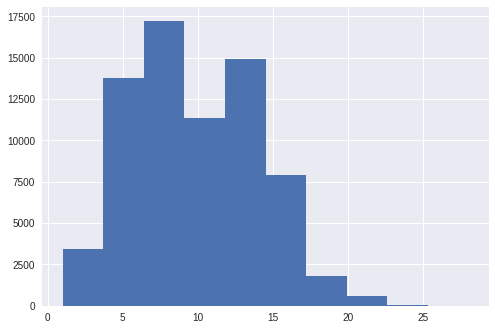

In [38]:
len_data = [len(seq) for seq in data_tokenized]
len_data = pd.Series(len_data)
len_data.hist()

## Word2Vec

In [39]:
model = Word2Vec(data_tokenized, 
                 size=32,
                 min_count=5,
                 window=10,
                 sg=0)

In [40]:
model.wv.most_similar('conversation')

[('talk', 0.7447591423988342),
 ('speak', 0.7413352131843567),
 ('afraid', 0.7270305752754211),
 ('traumatic', 0.7207926511764526),
 ('navigate', 0.7203397154808044),
 ('obsessive', 0.7189620733261108),
 ('especially', 0.7154746055603027),
 ('therapist', 0.7139221429824829),
 ('thought', 0.7099117040634155),
 ('photography', 0.7025721073150635)]

In [41]:
model.wv.most_similar('computer')

[('vision', 0.9332960247993469),
 ('quantum', 0.9005553722381592),
 ('field', 0.8688027858734131),
 ('humanlike', 0.85050368309021),
 ('algorithm', 0.8292948007583618),
 ('simulation', 0.8192020654678345),
 ('practitioner', 0.8112853169441223),
 ('intrigue', 0.8083462715148926),
 ('evolution', 0.8048787713050842),
 ('alphago', 0.7984660267829895)]

In [42]:
model.wv.most_similar('cat')

[('victoria', 0.931016206741333),
 ('ocd', 0.9235217571258545),
 ('crave', 0.9111674427986145),
 ('unfollow', 0.9014095067977905),
 ('pet', 0.8971247673034668),
 ('traumatize', 0.8967640995979309),
 ('intimacy', 0.8967178463935852),
 ('incredibly', 0.8964232802391052),
 ('possibly', 0.8937957286834717),
 ('stigmatize', 0.8934662342071533)]

In [43]:
model.corpus_count

71034

In [44]:
model.train(data_tokenized, total_examples=model.corpus_count, epochs=100, compute_loss=True) 

(68132049, 70071300)

In [45]:
model.wv.most_similar('conversation')

[('talk', 0.7595289945602417),
 ('borderline', 0.6276135444641113),
 ('colleague', 0.6145257353782654),
 ('discussion', 0.6120681762695312),
 ('discuss', 0.5708342790603638),
 ('awkward', 0.5693862438201904),
 ('speak', 0.5568907260894775),
 ('encounter', 0.544259786605835),
 ('youtuber', 0.5388836860656738),
 ('clearly', 0.5375357866287231)]

In [46]:
model.wv.most_similar('cat')

[('dog', 0.6803379058837891),
 ('inner', 0.6305431127548218),
 ('pet', 0.6130906343460083),
 ('possibly', 0.6107030510902405),
 ('weaknes', 0.6091322898864746),
 ('literally', 0.6021285057067871),
 ('hug', 0.5996850728988647),
 ('escape', 0.5763335824012756),
 ('exhusband', 0.5556436777114868),
 ('perfectly', 0.5487397909164429)]

In [47]:
model.wv.most_similar('computer')

[('identification', 0.6447179317474365),
 ('programmer', 0.6414215564727783),
 ('computational', 0.6334072351455688),
 ('compute', 0.6285775303840637),
 ('machine', 0.6229261755943298),
 ('vision', 0.6058835983276367),
 ('quantum', 0.6029714345932007),
 ('detection', 0.5964024662971497),
 ('ai', 0.5869786739349365),
 ('opencv', 0.5791851878166199)]

In [48]:
words = sorted(model.wv.vocab.keys(), 
               key=lambda word: model.wv.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

['learn', 'power', 'rise', '', 'student', 'robot', 'novel', 'guy', 'king', 'overcome']


In [49]:
word_vectors = np.array([model.wv.get_vector(i) for i in words])

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(word_vectors)
word_vectors_pca=pca.transform(word_vectors)

In [51]:
# draw it
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [52]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1003', ...)

Получим вектор для предложения - возьмем среднее векторов входящих в него слов

In [53]:
def get_seq_vector(seq):
  size = 32
  try:
    
    seq_vector = np.array([model.wv.get_vector(word) for word in seq])
    seq_vector = np.mean(seq_vector, axis=0)
    
  except KeyError:
    return np.zeros((1, size))
  return seq_vector.reshape((1, size))

In [54]:
text_vector = np.concatenate([get_seq_vector(seq) for seq in data_tokenized])

# Machine Learning

In [57]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [58]:
Data = text_vector
Data.shape

(71034, 32)

In [59]:
label = data['category']
label.shape

(71034,)

In [60]:
le = preprocessing.LabelEncoder()
le.fit(label)
label_encoded = le.transform(label)

In [61]:
train_data, test_data, train_labels, test_labels = train_test_split(Data, label_encoded, 
                                                                    test_size=0.3, stratify=label_encoded,
                                                                    random_state=42)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

In [183]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(train_data, train_labels)
pred_labels_proba = log_reg.predict_proba(test_data)
roc_auc_score(test_labels, pred_labels_proba, multi_class="ovr")

0.9626770461906539

In [191]:
pred_labels = log_reg.predict(test_data)
f1_score(test_labels, pred_labels, average='weighted')

0.642755302885075

In [129]:
%%time
parameters = {
    'C': np.arange(0.1, 1.1, 0.1)
    }
log_reg = LogisticRegression(max_iter=10000)
clf = GridSearchCV(log_reg, parameters, cv=5, scoring='roc_auc_ovr')
clf.fit(train_data, train_labels)

CPU times: user 24min 17s, sys: 16min 14s, total: 40min 32s
Wall time: 20min 40s


In [130]:
print(clf.best_score_, clf.best_params_)

0.9619516747783947 {'C': 1.0}


In [184]:
result_df = pd.DataFrame(le.inverse_transform(test_labels), columns=['category'])
result_df['true_prediction'] = test_labels == np.argmax(pred_labels_proba, axis=1)

In [185]:
result_df

,category,true_prediction
0,equality,True
1,work,True
2,culture,False
3,equality,True
4,family,True
...,...,...
21306,artificial-intelligence,True
21307,culture,False
21308,culture,False
21309,equality,False


In [186]:
pd.crosstab(result_df.category, result_df.true_prediction, normalize='index')

true_prediction,False,True
category,,
artificial-intelligence,0.350978,0.649022
business,0.415700,0.584300
cryptocurrency,0.251543,0.748457
culture,0.515789,0.484211
economy,0.532650,0.467350
environment,0.336592,0.663408
equality,0.365258,0.634742
family,0.467433,0.532567
health,0.512723,0.487277


Почти в каждой категории процент статей, верно отнесенных к этой категории больше, чем процент неверно отнесенных статей, но ошибок также достаточно много. Категория `technology` вероятно могда быть перепутана с другими схожими категориями (`artificial-intelligence`, `machine-learning`, `software-engineering`)

In [162]:
neigh = KNeighborsClassifier(metric='cosine')
neigh.fit(train_data, train_labels)
pred_labels = neigh.predict_proba(test_data)
roc_auc_score(test_labels,pred_labels, multi_class='ovr')

0.8793688960633864

In [173]:
%%time
parameters = {
    'n_neighbors': np.arange(50, 350, 50)
    }
neigh = KNeighborsClassifier(metric='cosine')
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc_ovr')
clf.fit(train_data, train_labels)

CPU times: user 4min 16s, sys: 12 s, total: 4min 28s
Wall time: 3min 43s


In [174]:
print(clf.best_score_, clf.best_params_)

0.9574878046481017 {'n_neighbors': 250}


In [193]:
neigh = KNeighborsClassifier(n_neighbors=250, metric='cosine')
neigh.fit(train_data, train_labels)
pred_labels_proba = neigh.predict_proba(test_data)
pred_labels = neigh.predict(test_data)
roc_auc = roc_auc_score(test_labels, pred_labels_proba, multi_class='ovr')
fscore = f1_score(test_labels, pred_labels, average='weighted')

In [194]:
print(f"ROC AUC: {roc_auc}\n F1-score: {fscore}")

ROC AUC: 0.9582311714759101
 F1-score: 0.6042155677039733


## Neural Networks

In [63]:
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Input, Embedding, Conv1D, Conv2D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, Flatten
from keras.metrics import AUC
# from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.layers import LSTM, Activation, MaxPooling1D, BatchNormalization

from keras.callbacks import EarlyStopping


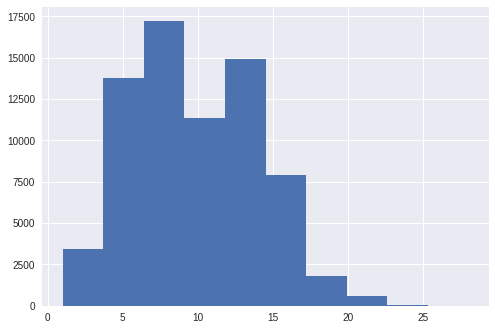

In [205]:
len_data.hist()

In [206]:
len_data.quantile(q=0.95)

17.0

In [64]:
ct = ColumnTransformer(
    [
        ("category", OneHotEncoder(sparse=False, categories='auto'), ["category"])
    ],
    remainder='drop'
)
ct.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('category',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['category'])],
                  verbose=False)

In [65]:
one_hot_features = pd.DataFrame(ct.transform(data), index=data.index,
                                columns=[x.replace('__x0', '') for x in ct.get_feature_names()])

In [66]:
one_hot_features.head()

,category_artificial-intelligence,category_business,category_cryptocurrency,category_culture,category_economy,category_environment,category_equality,category_family,category_health,category_javascript,category_machine-learning,category_marketing,category_mental-health,category_music,category_politics,category_relationships,category_science,category_social-media,category_software-engineering,category_technology,category_travel,category_work,category_writing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
Data = [" ".join(seq) for seq in data_tokenized]
label = one_hot_features.values

In [68]:
train_data,test_data,train_labels,test_labels = train_test_split(Data, label,test_size=0.1, 
                                                                 stratify=label, random_state=42)

In [70]:
max_words = len(model.wv.vocab)
max_len = int(len_data.quantile(q=0.95))

In [71]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(data_tokenized)

In [72]:
train_sequences = tok.texts_to_sequences(train_data)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len) 

test_sequences = tok.texts_to_sequences(test_data)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

print(train_sequences_matrix.shape, test_sequences_matrix.shape)

(63930, 17) (7104, 17)


In [73]:
embedding_matrix = np.array([model.wv[word] for word in model.wv.vocab.keys()])
embedding_matrix.shape

(6956, 32)

In [74]:
vector_dim = 32
num_classes = len(categories)

In [98]:
image_input = Input(shape=(max_len, ))
layer = Embedding(input_dim=max_words, output_dim=vector_dim, input_length=max_len, weights=[embedding_matrix])(image_input)
# layer = Dropout(0.7) (layer)
layer = Conv1D(filters=64, kernel_size=3, activation='relu')(layer)
avg_pl = GlobalAveragePooling1D()(layer)
max_pl = GlobalMaxPooling1D()(layer)

conc = concatenate([avg_pl, max_pl])

layer = Dense(num_classes, activation="sigmoid")(conc)
cnn_model = Model(inputs=image_input, outputs=layer)

In [99]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=AUC())

In [100]:
cnn_model.fit(train_sequences_matrix, train_labels, validation_split=0.05, epochs=10, batch_size=8)

Epoch 1/10
7592/7592 [==============================] - 38s 5ms/step - loss: 2.4936 - auc_3: 0.7706 - val_loss: 2.0313 - val_auc_3: 0.8482
Epoch 2/10
7592/7592 [==============================] - 38s 5ms/step - loss: 1.7986 - auc_3: 0.8824 - val_loss: 1.6716 - val_auc_3: 0.8939
Epoch 3/10
7592/7592 [==============================] - 38s 5ms/step - loss: 1.5181 - auc_3: 0.9110 - val_loss: 1.5194 - val_auc_3: 0.9098
Epoch 4/10
7592/7592 [==============================] - 36s 5ms/step - loss: 1.3551 - auc_3: 0.9245 - val_loss: 1.4280 - val_auc_3: 0.9183
Epoch 5/10
7592/7592 [==============================] - 36s 5ms/step - loss: 1.2383 - auc_3: 0.9339 - val_loss: 1.3891 - val_auc_3: 0.9236
Epoch 6/10
7592/7592 [==============================] - 36s 5ms/step - loss: 1.1480 - auc_3: 0.9403 - val_loss: 1.3420 - val_auc_3: 0.9287
Epoch 7/10
7592/7592 [==============================] - 36s 5ms/step - loss: 1.0734 - auc_3: 0.9457 - val_loss: 1.3064 - val_auc_3: 0.9322
Epoch 8/10
7592/7592 [=====

In [101]:
pred_labels = cnn_model.predict(train_sequences_matrix)
roc_auc_score(train_labels,pred_labels)

0.9592968348585945

In [102]:
pred_labels = cnn_model.predict(test_sequences_matrix)
roc_auc_score(test_labels,pred_labels)

0.9371893954035566

In [103]:
pred_labels = cnn_model.predict(test_sequences_matrix)
f1_score(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1), average='weighted')

0.6218717767130324

In [104]:
input = Input(shape=(max_len, ))
layer = Embedding(input_dim=max_words, output_dim=vector_dim, input_length=max_len, weights=[embedding_matrix], trainable=True)(input)
layer = LSTM(60)(layer)

layer = Dense(100, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(num_classes, activation='sigmoid')(layer)
lstm_model = Model(inputs=input, outputs=layer)

In [105]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=AUC())

In [106]:
lstm_model.fit(train_sequences_matrix, train_labels, validation_split=0.05, epochs=10, batch_size=8)

Epoch 1/10
7592/7592 [==============================] - 109s 14ms/step - loss: 2.3084 - auc_4: 0.8202 - val_loss: 1.7758 - val_auc_4: 0.8965
Epoch 2/10
7592/7592 [==============================] - 105s 14ms/step - loss: 1.6616 - auc_4: 0.9094 - val_loss: 1.5429 - val_auc_4: 0.9199
Epoch 3/10
7592/7592 [==============================] - 105s 14ms/step - loss: 1.4302 - auc_4: 0.9308 - val_loss: 1.4448 - val_auc_4: 0.9307
Epoch 4/10
7592/7592 [==============================] - 103s 14ms/step - loss: 1.2859 - auc_4: 0.9428 - val_loss: 1.3946 - val_auc_4: 0.9374
Epoch 5/10
7592/7592 [==============================] - 102s 13ms/step - loss: 1.1790 - auc_4: 0.9513 - val_loss: 1.3652 - val_auc_4: 0.9424
Epoch 6/10
7592/7592 [==============================] - 100s 13ms/step - loss: 1.0922 - auc_4: 0.9577 - val_loss: 1.3493 - val_auc_4: 0.9449
Epoch 7/10
7592/7592 [==============================] - 100s 13ms/step - loss: 1.0193 - auc_4: 0.9625 - val_loss: 1.3356 - val_auc_4: 0.9463
Epoch 8/10
75

In [108]:
pred_labels = lstm_model.predict(train_sequences_matrix)
roc_auc_score(train_labels,pred_labels)

0.9786936832894702

In [109]:
pred_labels = lstm_model.predict(test_sequences_matrix)
roc_auc_score(test_labels,pred_labels)

0.9468979462328871

In [110]:
pred_labels = lstm_model.predict(test_sequences_matrix)
f1_score(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1), average='weighted')

0.6153794760356643